# PI17 LOW Software Integration Test Plan -- Signal Chain

In this notebook we aim at demonstrating LOW Signal chain integration in the context of LOW PSI. In particular we will demonstrate how various elements in the signal chain can be operated though a common deployment in the Sydney LOW PSI. To do so we aim at deploying the various elements as depicted on the following Confluence page:. 

<img src="PI17_signal_chain.png" width="1200" title="Figure 1. Low PSI Signal chain integration"/>

In this Figure we are showing from left to right:
* an emulated station consisting of:
  * a signal generator with its SignalGenerator tango device
  * A Tile Processing Module with its associated tango device MccsTile pinned on the psi-node3 connected to TPM via subrack internal switch
  * A subrack management board with its associated tango device MccsSubrack pinned on psi-node3 connected to the management board via subrack internal switch
* an instance of LOW CBF consisting of: 
  * a programmable P4 switch with its associated tango device LowCbfConnector pinned on the P4 itself 
  * an Alveo Card to be initialised with the PST Beamformer personality with its associated tango device LowCbfConnector pinned on the Comtel server containing Alveo cards
  * an Alveo card to be initialised with the CNIC personality with its associated tango device LowCbfConnector also pinned on the Comtel server containing Alveo cards
* an instance of PST consisting of:
  * a PST receiver deployed on psi-pst1 while its associated tango device is deployed any PSI worker node
  * a PST disk writter deployed on psi-pst1 while its associated tango device is deployed any PSI worker node
  * a PST SMRB deployed on psi-pst1 while its associated tango device is deployed any PSI worker node
  
In this notebook, we implement the part of the signal chain from the signal generator to the a CNIC Alveo device, and inspect the captured data.
* The signal generator will generate a tone at 152MHz
* The TPM receives the signal and generate LFAA stream for frequency channels 192 to 200, sub array 0, and station beam 0
* The P4 switch is configured to perform the following 3 actions:
  * Reply to ARP requests from TPM so that the TPM can start sending LFAA data
  * Route LFAA data from the TPM for all frequencies to either a dedicated Alveo running the CNIC personality for data capture
* The CNIC FPGA will capture traffic from the TPM
* Using numpy and matplotlib we will analyse the data to identify the tone.

In [1]:
import json
import tango
import time
from itertools import groupby

def yield_attr_values(dev, attr):
    while True:
        yield dev.read_attribute(attr).value
        time.sleep(1)

def waitFor(dev, attr, desiredValue, quiet=False):
    for value, _ in groupby(yield_attr_values(dev, attr)):
        if not quiet:
            print(f"{dev.dev_name()}/{attr} = {value!r}")
        if value == desiredValue:
            return

def waitUntil(dev, attr, desiredValue):
    waitFor(dev, attr, desiredValue, quiet=True)

def pprint(obj):
    "pprint.pprint produce nice copy-pastable JSON" 
    print(json.dumps(obj, indent=2))

## Signal Generator Configuration

We could configure the signal generator to produce a tone at 80MHz, 0dBm.

In [122]:
siggen = tango.DeviceProxy("tango-databaseds.staging:10000/psi-low/siggen/1")
siggen.adminMode = 0
waitUntil(siggen, "state", tango.DevState.ON)

siggen.frequency = 152_000_000
siggen.power_dbm = -36
siggen.rf_output_on = True

## TPM Configuration

For the TPM to send data over its 40G link, we need three things:
1. A destination IP needs to be configured
2. We need to have called StartAcquisition()
3. We need to configure and start the beamformer



### Bring the subrack online and turn off power to the TPM

In [3]:
import tango

subrack = tango.DeviceProxy("tango-databaseds.staging:10000/low-mccs/subrack/0001")
subrack.adminMode = 0
waitUntil(subrack, "state", tango.DevState.ON)

subrack.PowerDownTpms()

[array([2], dtype=int32), ['1677172857.1855931_120124481779466_PowerDownTpms']]

### Bring the TPM online and wait for it to initialise

The TPM will be physically off, so we bring the device online and wait for its state to reflect that with `DevState.OFF` before calling `tile.On()`.

When the tile turns on, it goes through an initialisation phase tracked by the attribute tileProgrammingState, ending once this attribute reads `Initialised`.

In [8]:
tile = Device("low-mccs/tile/0005")
tile.adminMode = 0
waitUntil(tile, "state", tango.DevState.UNKNOWN) # bug - should be OFF

tile.On()
waitFor(tile, "tileProgrammingState", "Initialised")

low-mccs/tile/0005/tileProgrammingState = 'Off'
low-mccs/tile/0005/tileProgrammingState = 'NotProgrammed'
low-mccs/tile/0005/tileProgrammingState = 'Programmed'
low-mccs/tile/0005/tileProgrammingState = 'Initialised'


### Configure a downstream destination IP

For the TPM to have any interest in sending packets, we need to set the downstream destination IP to something other than 0.0.0.0. We're using fpga2 in this test, which corresponds to core_id 1.

In [9]:
# This doesn't work (TODO: and probably should raise an error?):
tile.Configure40GCore('{"core_id": 1, "destination_ip": "192.168.1.1"}')
fortyg_config = json.loads(tile.Get40GCoreConfiguration('{"core_id": 1}'))
pprint(fortyg_config)

{
  "core_id": 1,
  "arp_table_entry": 0,
  "source_mac": 107752307294935,
  "source_ip": "10.0.2.215",
  "source_port": 61648,
  "destination_ip": "0.0.0.0",
  "destination_port": 4660
}


In [10]:
# See? Instead, we need to supply a complete config. So let's
# modify the one we just read and re-submit it.
fortyg_config["destination_ip"] = "192.168.1.1"
tile.Configure40GCore(json.dumps(fortyg_config))
pprint(json.loads(tile.Get40GCoreConfiguration('{"core_id":  1}')))

{
  "core_id": 1,
  "arp_table_entry": 0,
  "source_mac": 107752307294935,
  "source_ip": "10.0.2.215",
  "source_port": 61648,
  "destination_ip": "192.168.1.1",
  "destination_port": 4660
}


### Configure and start the TPM beamformer

The TPM still won't have any packets to send to CBF until the beamformer is running, and the beamformer won't have any beams to form until we start acquisition, which (TODO: starts the data processing pipeline on the TPM? And synchronises something?)

In [11]:
tile.StartAcquisition('{}') # specify time if multiple tile
waitFor(tile, "tileProgrammingState", "Synchronised")

low-mccs/tile/0005/tileProgrammingState = 'Initialised'
low-mccs/tile/0005/tileProgrammingState = 'Synchronised'


In [13]:
tile.logginglevel = 5

Next we configure and start the beamformer (the order here is important). (150781250 replace 151_171_875)

In [11]:
tile.ConfigureTestGenerator(json.dumps({
    "tone_frequency": 8800000, 
    "tone_amplitude": 0.08,
    "noise_amplitude": 0.0,
}))

[array([0], dtype=int32), ['ConfigureTestGenerator command completed OK']]

In [107]:
tile.StopBeamformer()

[array([0], dtype=int32), ['StopBeamformer command completed OK']]

In [108]:
tile.ConfigureStationBeamformer(json.dumps({"start_channel": 192, "n_channels": 8, "is_first": True, "is_last": True}))
tile.channeliserRounding = [0]
tile.cspRounding = [0]
tile.SetBeamFormerRegions([192,8,0,0,0,0,0,0])

[array([0], dtype=int32), ['SetBeamFormerRegions command completed OK']]

In [109]:
tile.StartBeamformer('{}')

[array([0], dtype=int32), ['StartBeamformer command completed OK']]

## P4 Configuration 

### Setup 

Before starting, make sure that the latest stable ska-low-cbf-conn chart is deployed in PSI, using the ska-low-cbf-conn namespace. If not, install it with the following command:

`make k8s-install-chart`

We can then get access to the connector device and check that we are connected to the physical switch. This should either connect to the switch (`[array([0], dtype=int32), ['Connecting to switch']]`) or would inform us that the Tango device is already connected (`[array([0], dtype=int32), ['Already connected to the switch']]`)

In [17]:
cbf_conn_db = "tango-databaseds.ska-low-cbf-conn:10000"
connector = tango.DeviceProxy(f"{cbf_conn_db}/low-cbf/connector/0")
connector.ConnectToSwitch('{"Switch": "202.9.15.135:50052"}')

[array([0], dtype=int32), ['Already connected to the switch']]

### Configure the ports for the TPM and Alveo FPGAs

First let's define a function to make it easy to get the status of one or all ports:

In [18]:
def get_port_status(dev, port_name=None):
    ports = json.loads(dev.portStatus)["Ports_Status"]
    if port_name:
        ports = [p for p in ports if p["$PORT_NAME"] == port_name]
    return ports

In [19]:
# TODO: this should be based on physical identity not Tango device name
TPM_PORT_MAP = {
    "low-mccs/tile/0002": "27/0",
    "low-mccs/tile/0005": "29/0",
}

TPM_P4_PORT = TPM_PORT_MAP[tile.name()]

if get_port_status(connector, TPM_P4_PORT):
    connector.RemovePorts(json.dumps({"Physical": [{"port": TPM_P4_PORT}]}))

connector.LoadPorts(json.dumps({"Physical": [
    # {"port": "10/0", "speed": "100G", "fec": "none", "autoneg": "disable", "mac": "84:c7:8f:03:79:b2"},
    # {"port": "11/0", "speed": "100G", "fec": "none", "autoneg": "disable", "mac": "84:c7:8f:03:79:b2"},
    {"port": TPM_P4_PORT, "speed": "40G",  "fec": "none", "autoneg": "disable", "mac": "84:c7:8f:03:79:b2"},
]}))

[array([0], dtype=int32), ['Port Configured']]

### Checking the various port status 

In order to check the port status, let's first define a function to retrieve ports' information. In particular, we want to retrieve information about all currently configured ports. In this context, a configured port is a port for which we have specified the speed using the `loadports()` function. This means that if a port is not present, it has not been configured yet.

In [20]:
def print_port_status(port_statuses):
    for p in port_statuses:
        print(f"Port {p['$PORT_NAME']:<6}  Enable: {p['$PORT_ENABLE']:<3}   Up: {p['$PORT_UP']:<3}   Speed: {p['$SPEED']:<6}   Rx: {p['packets_received']:<6}    Tx: {p['packets_sent']:6}")

def monitor_port_status(dev, n, i=4):
    for j in reversed(range(i)):
        print_port_status(get_port_status(dev, n))
        if j:
            time.sleep(1)

In [21]:
# tpm_port_status = get_port_status(connector, TPM_PORT_MAP[tile.name()])
# monitor_port_status(connector, TPM_PORT_MAP[tile.name()])
monitor_port_status(connector, "29/0")

Port 29/0    Enable: 1     Up: 1     Speed: 40G      Rx: 2368      Tx:      0
Port 29/0    Enable: 1     Up: 1     Speed: 40G      Rx: 6272      Tx:      0
Port 29/0    Enable: 1     Up: 1     Speed: 40G      Rx: 10608     Tx:      0
Port 29/0    Enable: 1     Up: 1     Speed: 40G      Rx: 14952     Tx:      0


At this point the TPM port as well as the target Alveo port should both be enable. If not we can configure them with the `loadport` method. For example with the following would add port 10/0 and 11/0 at 100G and not FEC while port 27/0 is going to be configured at 40G without FEC.

`connector.loadports('{"Physical": [{"port": "10/0", "speed": "100G", "fec": "none", "autoneg": "disable", "mac": "84:c7:8f:03:79:b2" }, {"port": "11/0", "speed": "100G", "fec": "none", "autoneg": "disable", "mac": "84:c7:8f:03:79:b2" }, {"port": "27/0", "speed": "40G", "fec": "none", "autoneg": "disable", "mac": "84:c7:8f:03:79:b2" }]}')`

We can reset the statistics on all ports with `connector.ResetPortStatistics()` method.


### ARP configuration 

Before the TPM can send data it needs to find the MAC address for a pre-defined IP address 192.168.1.1. This is configured inside the ARP routing table via the following methods:
* `AddARPEntry`: to add an entry in this table
* `UpdateARPEntry`: to update an entry in this table
* `RemoveARPEntry`: to remove an entry in this table
* `ClearARPTable`: to empty the full table
* `arpRoutingTable`: to retrieve the ARP routing table

Let's first check if there is anything configured in the table


In [22]:
import json
def parse_arp_table():
    return {
        arp["IP"].strip(): arp["Mac"]
        for arp in json.loads(connector.arpRoutingTable)["ARP"]
    }

def print_arp_status():
    print("ARP table for automatic replies:")
    for ip, mac in parse_arp_table().items():
        print(f"IP: {ip:<15}  MAC: {mac:<17}")

print_arp_status()

ARP table for automatic replies:
IP: 192.168.1.1      MAC: aa:bb:cc:dd:ee:ff


If there is nothing in the table we can now add a ARP resolution. In this case, we will add an entry for the IP address necessary to start the TPM, 192.168.1.1

In [23]:
if "192.168.1.1" in parse_arp_table():
    cmd = connector.UpdateARPEntry
else:
    cmd = connector.AddARPEntry
cmd('{"arp": [{"ip": {"address": "192.168.1.1"}, "mac": {"address": "aa:bb:cc:dd:ee:ff"}}]}')

[array([0], dtype=int32), ['Routes_Added']]

Let's check that this is correct

In [24]:
print_arp_status()

ARP table for automatic replies:
IP: 192.168.1.1      MAC: aa:bb:cc:dd:ee:ff


You can remove these entries with the following method `connector.RemoveARPEntry('{"arp": [{"ip": {"address": "192.168.1.1"}}]}')`

## CNIC configuration

_In this section, we essentially need to adapt the "RX" part of the demo script at https://gitlab.com/ska-telescope/low-cbf/ska-low-cbf-proc/-/snippets/2458504._


### Setup 

Before starting, make sure that you have deployed at least 2 processor Tango devices. For the reminder of this notebook we will assume that these Tango devices have been deployed within the `low-csp` namespace.

In [25]:
import os
import tango

db = tango.Database()

db_query = db.get_device_exported_for_class("LowCbfProcessor")

fqdns = [_ for _ in db_query.value_string]
assert len(fqdns) >= 1, "Not enough Processors!"

rx_proc = tango.DeviceProxy(fqdns[0])
processors = [rx_proc]

Declare a mapping between specific Alveo cards and P4 ports.

In [26]:
alveo_port_mapping = {
    "XFL1ZIN0F4RO": "42/0",
    "XFL14SLO1LIF": "44/0",
    "XFL1DKXBEVG2": "46/0",
    "XFL1HOOQ1Y44": "48/0",
    "XFL1VCYSXCL0": "50/0",
    "XFL10NIYKVEU": "52/0",
    "XFL1LHN4TXO2": "54/0",
    "XFL1XCRTUC22": "56/0",
    "XFL1E35JVJTQ": "58/0",
    "XFL1RCFEG244": "60/0",
}

### CNIC Software

Install cnic software for use later

In [27]:
import os
import sys

os.environ["https_proxy"] = "http://delphoenix.atnf.csiro.au:8888"
!{sys.executable} -m pip install --extra-index-url https://artefact.skao.int/repository/pypi-internal/simple ska-low-cbf-sw-cnic

Looking in indexes: https://pypi.org/simple, https://artefact.skao.int/repository/pypi-internal/simple
  Using cached https://artefact.skao.int/repository/pypi-internal/packages/ska-low-cbf-sw-cnic/0.3.7/ska_low_cbf_sw_cnic-0.3.7-py3-none-any.whl (27 kB)
  Using cached https://artefact.skao.int/repository/pypi-internal/packages/ska-low-cbf-fpga/0.15.0/ska_low_cbf_fpga-0.15.0-py3-none-any.whl (33 kB)
  Using cached rich-12.6.0-py3-none-any.whl (237 kB)
  Using cached dpkt-1.9.8-py3-none-any.whl (194 kB)
  Using cached scapy-2.5.0-py2.py3-none-any.whl
  Using cached commonmark-0.9.1-py2.py3-none-any.whl (51 kB)
  Using cached parsimonious-0.8.1-py3-none-any.whl
  Using cached ipython-7.34.0-py3-none-any.whl (793 kB)
  Using cached blessed-1.20.0-py2.py3-none-any.whl (58 kB)
  Attempting uninstall: ipython
    Found existing installation: ipython 8.5.0
    Uninstalling ipython-8.5.0:
      Successfully uninstalled ipython-8.5.0


### Personality assignement and load

Here we are downloading the CNIC personality and turning it on on the selected alveo. 

In [28]:
print("Selecting CNIC personality")
for proc in processors:
    print(proc)
    #proc.simulationMode = 1
    proc.set_timeout_millis(60_000)
    proc.SelectPersonality('{"personality": "cnic", "source": "gitlab", "version": "0.1.4-dev.ec712610", "platform": 3}')

Selecting CNIC personality
LowCbfProcessor(low-cbf/processor/0.0.0)


In [29]:
import time 
print("Turning off Simulation mode")
for proc in processors:
    if proc.simulationMode:
        proc.simulationMode = 0
time.sleep(5)

Turning off Simulation mode


In [30]:
print("Setting Admin mode to Online")
for proc in processors:
    if proc.adminMode:
        proc.adminMode = 0
print(rx_proc.adminMode)

Setting Admin mode to Online
adminMode.ONLINE


In [31]:
print("Checking FPGA attributes exist (i.e. polling is active)\n")
for proc in processors:
    max_attempts = 10
    for i in range(max_attempts + 1):
        if "system__time_uptime" in proc.get_attribute_list():
            print("success")
            break
        if i == max_attempts:
            raise RuntimeError(
                '"system__time_uptime" not found in attribute list'
            )
        time.sleep(2)


Checking FPGA attributes exist (i.e. polling is active)

success


In [32]:
print("Confirming FPGA operation:")
for proc in processors:
    print(f"{proc.name()} FPGA Uptime", proc.system__time_uptime)
print("")

Confirming FPGA operation:
low-cbf/processor/0.0.0 FPGA Uptime 2078



In [33]:
print(rx_proc.get_attribute_list())
print(rx_proc.system__time_uptime)

['buildState', 'versionId', 'loggingLevel', 'loggingTargets', 'healthState', 'adminMode', 'controlMode', 'simulationMode', 'testMode', 'longRunningCommandsInQueue', 'longRunningCommandIDsInQueue', 'longRunningCommandStatus', 'longRunningCommandProgress', 'longRunningCommandResult', 'serialNumber', 'finished_receive', 'fw_version', 'ready_to_transmit', 'fw_personality', 'cmac__cmac_stat_rx_total_packets', 'cmac__cmac_stat_rx_multicast', 'cmac__cmac_stat_tx_total_good_packets', 'cmac__cmac_stat_rx_broadcast', 'cmac__cmac_stat_rx_toolong', 'cmac__cmac_stat_rx_packet_4096_8191_bytes', 'cmac__cmac_stat_rx_packet_512_1023_bytes', 'cmac__cmac_stat_rx_packet_small', 'cmac__cmac_stat_rx_packet_64_bytes', 'cmac__cmac_stat_rx_packet_1519_1522_bytes', 'cmac__cmac_stat_rx_packet_bad_fcs', 'cmac__cmac_stat_rx_stomped_fcs', 'cmac__cmac_stat_tx_total_packets', 'cmac__cmac_stat_rx_total_good_packets', 'cmac__cmac_stat_rx_bad_fcs', 'cmac__cmac_stat_rx_fragment', 'cmac__cmac_stat_rx_packet_1549_2047_byte

## Enable CNIC port's on P4 switch and route between the two ports

In [38]:
if get_port_status(connector, alveo_port):
    connector.RemovePorts(json.dumps({"Physical": [{"port": alveo_port}]}))

connector.LoadPorts(json.dumps({"Physical": [
    {"port": alveo_port, "speed": "100G",  "fec": "none", "autoneg": "disable", "mac": "84:c7:8f:03:79:b2"},
]}))

[array([0], dtype=int32), ['Port Configured']]

In [34]:
basic_table = json.loads(connector.basicRoutingTable)['Basic']
basic_routes = {(r['ingress port'], r['port']) for r in basic_table}

tpm_port = TPM_PORT_MAP[tile.name()]
alveo_port = alveo_port_mapping[rx_proc.serialNumber]

if (tpm_port, alveo_port) not in basic_routes:
    connector.AddBasicEntry(json.dumps({
        "basic": [
            {
                "src": {"port": tpm_port},
                "dst": {"port": alveo_port},
            },
        ],
    }))

In [36]:
connector.basicRoutingTable

'{"Basic": [{"ingress port": "46/0", "port": "52/0"}, {"ingress port": "29/0", "port": "42/0"}]}'

### CNIC data capture

We just have to configure the CNIC to receive a given number of packets and where to store the results. We're grabbing 8 packets, which gives us 4096 samples per channel.

In [153]:
RX_JSON = """{
  "method": "receive_pcap",
  "arguments": {
    "out_filename": "/test-data/Viola/cnic.pcap",
    "packet_size": 8306,
    "n_packets": 8
  }
}"""

In [155]:
print(f"Configuring {rx_proc.name()} for Rx\n")
rx_proc.CallMethod(RX_JSON)

Configuring low-cbf/processor/0.0.0 for Rx



[array([0], dtype=int32), ['OK']]

## Analysis of recorded traffic 

Hereafter we perform a general analysis of the SPS traffic. First, we need to install scapy. Second, we can define various functions to analyse the traffic. Finally, we can analyse the SPS data. 

In [45]:
import os
import sys

os.environ["https_proxy"] = "http://delphoenix.atnf.csiro.au:8888"
!{sys.executable} -m pip install scapy ipympl

In [46]:
import matplotlib.pyplot as plt
import numpy as np

from scapy.all import PcapReader, PcapNgReader

In [47]:
def get_hex_from_byte(byte, first, last):
    """
    Extract bits[first:last] from given byte(s) and converts into hex. Assumes valid inputs.
    """

    integer = int.from_bytes(byte, "big")
    binary = bin(integer)

    binary = binary[2:]  # extract '0b' prefix
    sub_binary_str = binary[first:last]
    return "0x{:04x}".format(int(sub_binary_str, 2))

In [48]:
def inspect_spead(header, field=None):
    """
    Returns spead field value. Assumes valid inputs.

    :params
        header: bytestring of spead header.
        field: interested spead field.
    """

    spead_lookup = {
        "magic_num": "0x{:02x}".format(int.from_bytes(header[0:1], "big")),
        "version": "0x{:02x}".format(int.from_bytes(header[1:2], "big")),
        "item_ptr_width": "0x{:02x}".format(
            int.from_bytes(header[2:3], "big")
        ),
        "heap_addr_width": "0x{:02x}".format(
            int.from_bytes(header[3:4], "big")
        ),
        "num_items": "0x{:02x}".format(int.from_bytes(header[6:8], "big")),
        "heap_counter": get_hex_from_byte(bytes(header)[8:10], 1, 16),
        "logical_id": int.from_bytes(header[10:12], "big"),
        "packet_counter": int.from_bytes(header[12:16], "big"),
        "pkt_len": get_hex_from_byte(bytes(header)[16:18], 1, 16),
        "packet_payload_length": int.from_bytes(header[18:24], "big"),
        "sync_time": get_hex_from_byte(bytes(header)[24:26], 1, 16),
        "unix_epoch_time": int.from_bytes(header[26:32], "big"),
        "timestamp_hex": get_hex_from_byte(bytes(header)[32:34], 1, 16),
        "timestamp_ns": int.from_bytes(header[34:40], "big"),
        "center_freq": get_hex_from_byte(bytes(header)[40:42], 1, 16),
        "frequency": int.from_bytes(header[44:48], "big"),
        "csp_channel_info": get_hex_from_byte(bytes(header)[48:50], 1, 16),
        "beam_id": int.from_bytes(header[52:54], "big"),
        "frequency_id": int.from_bytes(header[54:56], "big") & 0x3ff,
        "csp_antenna_info": get_hex_from_byte(bytes(header)[56:58], 1, 16),
        "substation_id": int.from_bytes(header[58:59], "big"),
        "subarray_id": int.from_bytes(header[59:60], "big"),
        "station_id": int.from_bytes(header[60:62], "big"),
        "nof_contributing_antenna": int.from_bytes(header[62:64], "big"),
        "sample_offset": get_hex_from_byte(bytes(header)[64:66], 1, 16),
    }

    return spead_lookup[field] if field else spead_lookup

In [49]:
def inspect(packet, protocol, field):
    """
    Prints protocol's header information.

    :params
        packet: Packet object to inspect.
        protocol: a string that specifies which protocol's header to inspect.
        field: a string that specifies which field to inspect.
    :options
        'Ether': 'dst', 'src', 'type'.
        'IPv4': 'version', 'ihl', 'tos', 'len', 'id', 'flags', 'frag', 'ttl', 'proto', 'chksum', 'src', 'dst'.
        'UDP': 'sport', 'dport', 'len', 'chksum'
    """
    if protocol == "spead":
        header = packet["UDP"].payload
        # print(protocol + '_' + field + ': ' + str(inspect_spead(bytes(header)[0:72], field)))
        return inspect_spead(bytes(header)[0:72], field)
    else:
        # print(protocol + '_' + field + ': ' + getattr(packet[protocol], field))
        return getattr(packet[protocol], field)

In [50]:
# Plot VR/VI/HR/HI v. packet number


def pols_pktnum(pol_data):
    VR = pol_data["VR"]
    VI = pol_data["VI"]
    HR = pol_data["HR"]
    HI = pol_data["HI"]
    # plot packets
    figure, axis = plt.subplots(2, 2)

    axis[0, 0].plot(VR)
    axis[0, 0].set_title("VR")

    axis[0, 1].plot(VI)
    axis[0, 1].set_title("VI")

    axis[1, 0].plot(HR)
    axis[1, 0].set_title("HR")

    axis[1, 1].plot(HI)
    axis[1, 1].set_title("HI")

    figure.tight_layout()

    plt.show()

In [156]:
# Driver code block

#filename = "96cc_6stat_tone_udp_dest_4660_first_1728_pkts.pcap"
filename = "../cbf-data/Viola/cnic.pcap"

packet_count = 0
interested_freq = 119531250
inspect_packet = range(0, 100)  # list of packets to inspect
channel_data = {}
pkts_data = {}
polarisations = ["VR", "VI", "HR", "HI"]

from collections import defaultdict, Counter
samples_per_channel = defaultdict(lambda: 0)
counters = defaultdict(Counter)
# discover frequency channels present
frequencies = set()
for packet in PcapReader(filename):
    spead = inspect_spead(bytes(packet["UDP"].payload)[:72])
    for field in spead:
        if not (field.startswith("timestamp") or field == "packet_counter"):
            counters[field].update([spead[field]])
    channel = inspect(packet, "spead", "frequency_id")
    frequencies.add((channel, inspect(packet, "spead", "frequency")))
    # don't count spead header, divide by 4 for (vertical, horizontal) * (real, imaginary)
    samples_per_channel[channel] += (len(packet["UDP"].payload) - 72) // len(polarisations)
for field, counter in sorted(counters.items()):
    if len(counter) == 1:
        print(f"{field}: {next(iter(counter))}")
    else:
        print(f"{field} ({len(counter)}): {counter.most_common()}")

print("Channels:")
print("\n".join(f"  {ch} ({fr}Hz)" for ch, fr in sorted(frequencies)))

print("Samples per channel", samples_per_channel.items())
channel_lookup = list(samples_per_channel.keys())
channels = len(samples_per_channel)
n_pol = len(polarisations)
time_steps = max(samples_per_channel.values())
samples = np.zeros((channels, n_pol, time_steps), dtype=np.int8)
print("samples shape", samples.shape)

# dodgy - assumes no missed packets. should use timestamps instead
samples_collated_per_channel = defaultdict(lambda: 0)
first = True
debug = True
seen = set()
for i, packet in enumerate(PcapReader(filename)):
    channel = inspect(packet, "spead", "frequency_id")
    channel_index = channel_lookup.index(channel)
    # packet_data = np.frombuffer(bytes(packet["UDP"].payload)[72:], dtype=">B")  # 72B of SPEAD header
    packet_data = np.frombuffer(bytes(packet["UDP"].payload)[72:], dtype=np.int8)  # 72B of SPEAD header
    packet_samples = packet_data.reshape(-1, len(polarisations)).T
    if channel not in seen:
        seen.add(channel)
        print(f"channel {channel}, logical {inspect(packet, 'spead', 'logical_id')}, cnt {inspect(packet, 'spead', 'packet_counter')}, freq {inspect(packet, 'spead', 'frequency')}")
        print(f"nof_contributing_antenna: {inspect(packet, 'spead', 'nof_contributing_antenna')}")
        print("First bytes of packet_data:", packet_data[0:16])
        print("packet_samples shape:", packet_samples.shape)
        for _ in range(4):
            for n, pol in enumerate(polarisations):
                print(f"pol {pol} sample {_}:", packet_samples[n][_])
            print("")

    start_sample = samples_collated_per_channel[channel]
    n_samples = packet_samples.shape[1]
    samples[channel_index, :, start_sample:start_sample+n_samples] = packet_samples
    samples_collated_per_channel[channel] += n_samples

if debug:
    print(samples[0, :, 0:8])

beam_id: 0
center_freq: 0x1011
csp_antenna_info: 0x3001
csp_channel_info: 0x3000
frequency (4): [(150781250, 2), (152343750, 2), (153906250, 2), (155468750, 2)]
frequency_id (4): [(193, 2), (195, 2), (197, 2), (199, 2)]
heap_addr_width: 0x06
heap_counter: 0x0001
item_ptr_width: 0x02
logical_id (4): [(1, 2), (3, 2), (5, 2), (7, 2)]
magic_num: 0x53
nof_contributing_antenna: 0
num_items: 0x08
packet_payload_length: 8192
pkt_len: 0x0004
sample_offset: 0x1300
station_id: 0
subarray_id: 0
substation_id: 0
sync_time: 0x1027
unix_epoch_time: 1677172953
version: 0x04
Channels:
  193 (150781250Hz)
  195 (152343750Hz)
  197 (153906250Hz)
  199 (155468750Hz)
Samples per channel dict_items([(193, 4096), (195, 4096), (197, 4096), (199, 4096)])
samples shape (4, 4, 4096)
channel 193, logical 1, cnt 1312798, freq 150781250
nof_contributing_antenna: 0
First bytes of packet_data: [ 0 -2  0 -1  7  0  2  0 21  8  0 -1  1  3  0 -1]
packet_samples shape: (4, 2048)
pol VR sample 0: 0
pol VI sample 0: -2
pol 

In [ ]:
%matplotlib inline
# Plot number of packets v. frequency.
print(samples_per_channel.items())

plt.bar(samples_per_channel.keys(), samples_per_channel.values()) #, color="blue", width=1e5)
plt.title("Samples per Channel")
plt.tight_layout()
plt.rcParams["figure.figsize"] = (20, 5)
plt.show()



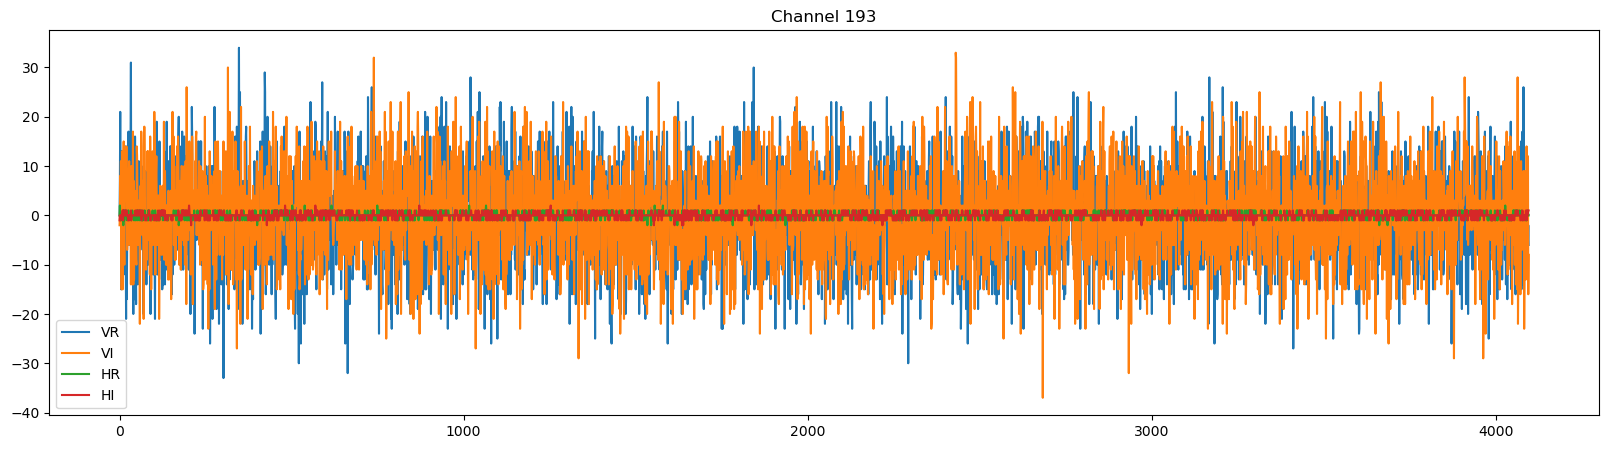

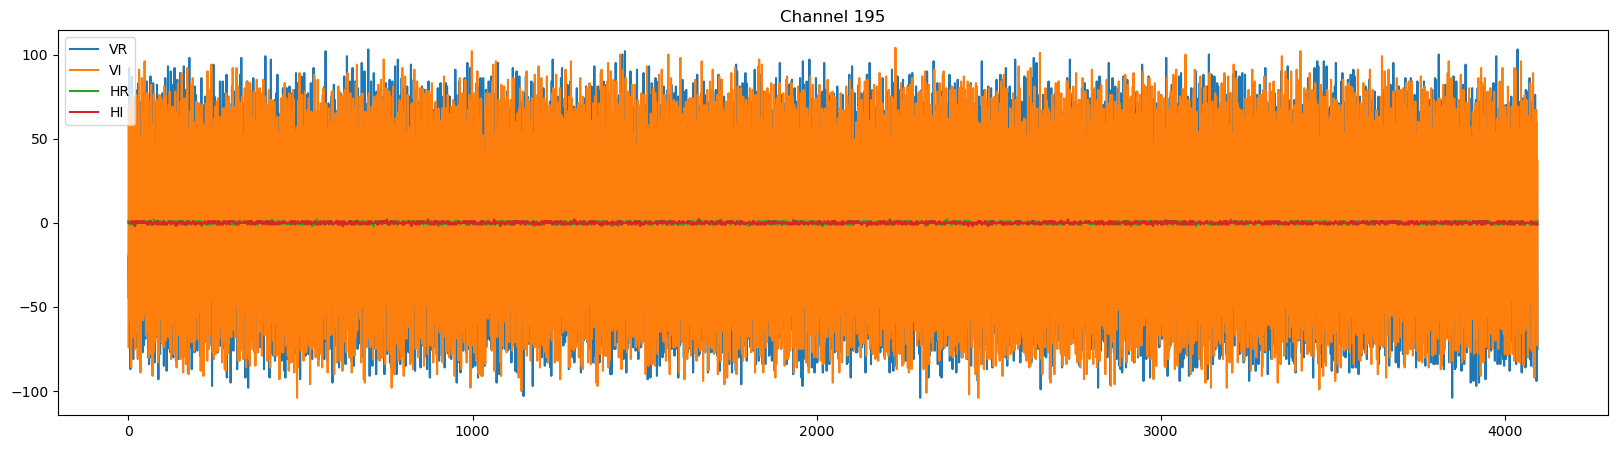

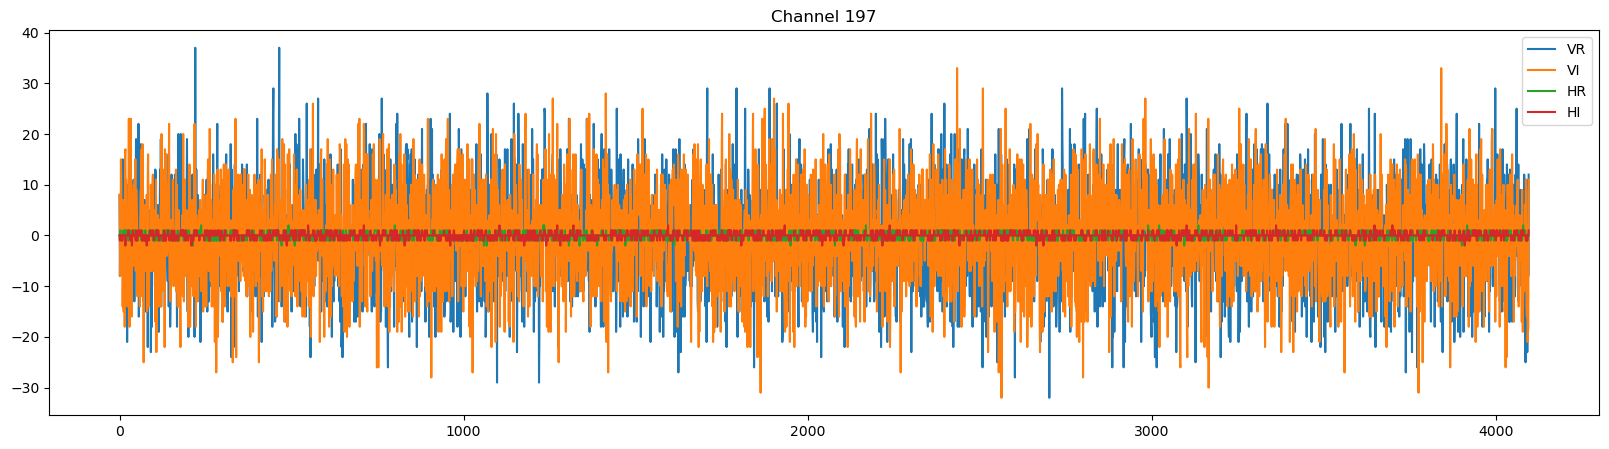

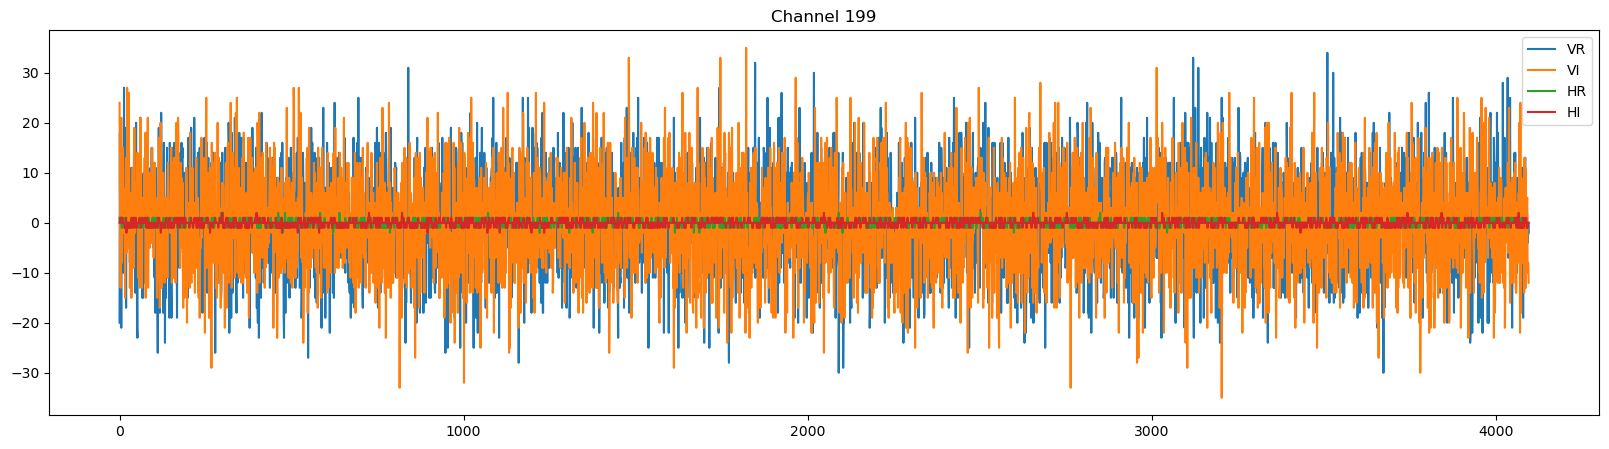

In [158]:
# Plot VR/VI/HR/HI v. time for each channel
# TODO: figure out timestamps



import matplotlib.pyplot as plt

for n_chan, channel in enumerate(channel_lookup):
    plt.figure()
    # n_chan is used to index our all samples data array
    for i, polarisation in enumerate(polarisations):
        plt.plot(samples[n_chan][i], label=polarisation)

    plt.title(f"Channel {channel}")
    plt.legend()


In [ ]:
# Plot histogram
import matplotlib.pyplot as plt

polarisation_colour = ["blue", "orange", "green", "red"]
for n_chan, channel in enumerate(channel_lookup):
    # n_chan is used to index our all samples data array
    # one subplot per polarisation
    fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2, sharex=True, sharey=True)
    for i, polarisation in enumerate(polarisations):
        locals()[f"ax{i}"].hist(samples[n_chan][i], label=polarisation, color = polarisation_colour[i])
    fig.suptitle(f"Channel {channel}")
    fig.legend()

In [ ]:
# Plot FFT of each polarisation (linear scale)
# ref: https://pythonnumericalmethods.berkeley.edu/notebooks/chapter24.04-FFT-in-Python.html
from numpy.fft import fft, fftshift

polarisation_colour = ["blue", "orange", "green", "red"]
ADC_SAMPLE_PERIOD = 1.28e-6
OS_FACTOR = 32/27
# TODO - check if OS factor should be multiplied instead?
sample_rate = (1 / ADC_SAMPLE_PERIOD) * (OS_FACTOR)

for n_chan, channel in enumerate(channel_lookup):
    plt.figure()
    # n_chan is used to index our all samples data array
    for n_pol, polarisation in enumerate(polarisations):
        x = samples[n_chan][n_pol]
        x_fft = fftshift(fft(x))
        N=len(x)
        n = np.arange(N)
        T = N/sample_rate
        freq = n/T
        colour = polarisation_colour[n_pol]
        plt.stem(freq, np.abs(x_fft), colour, markerfmt=" ", basefmt=colour, label=polarisation)
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("FFT")

    plt.title(f"Channel {channel}")
    plt.legend()

925699.8697916666
0.0
925699.8697916666
0.0
925699.8697916666
0.0
925699.8697916666
0.0


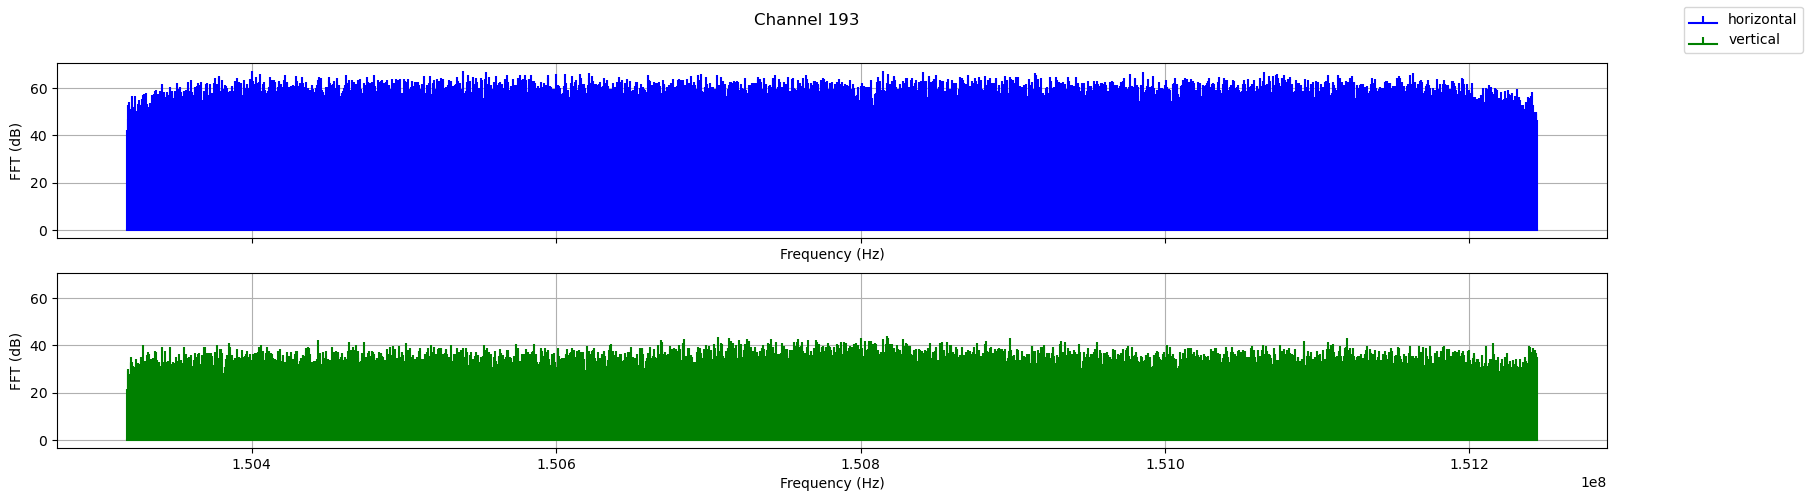

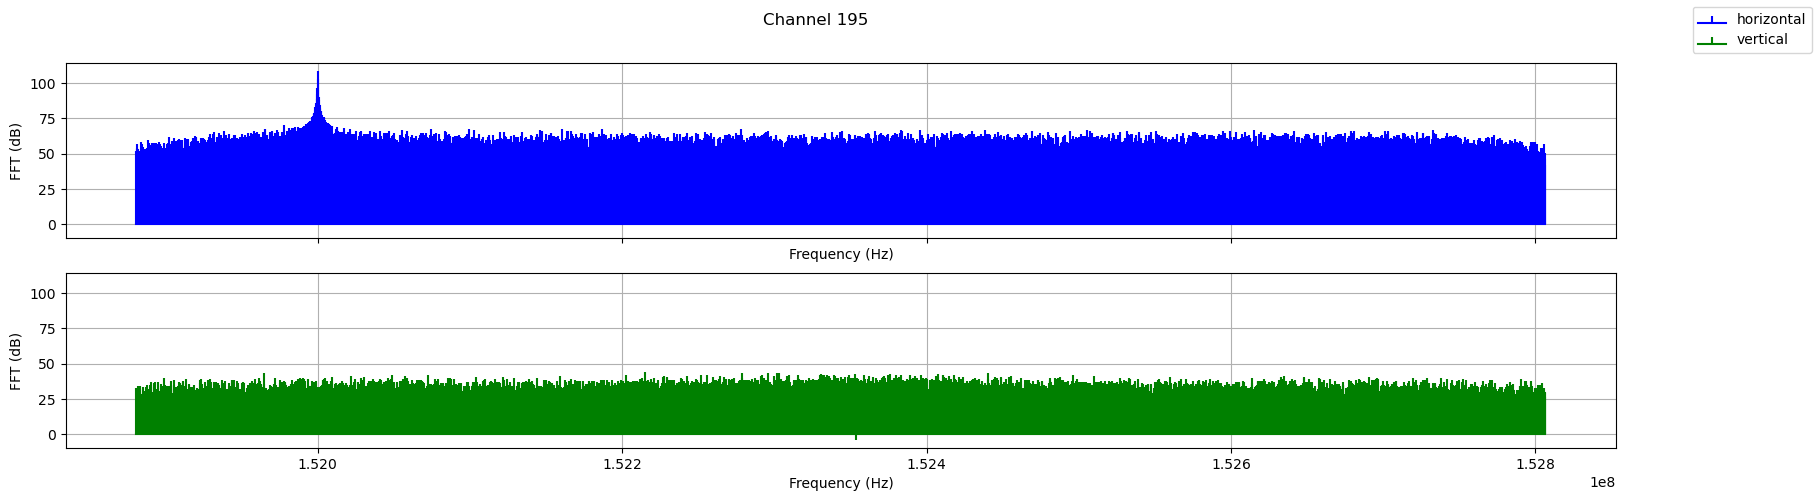

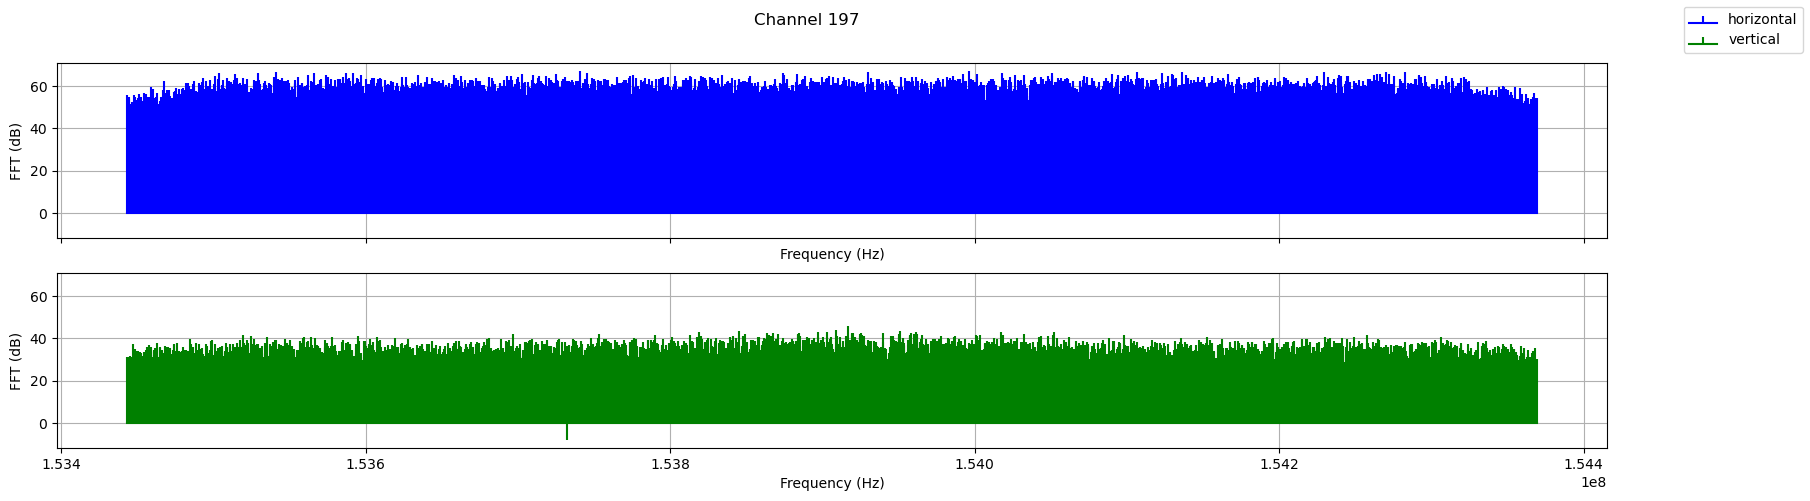

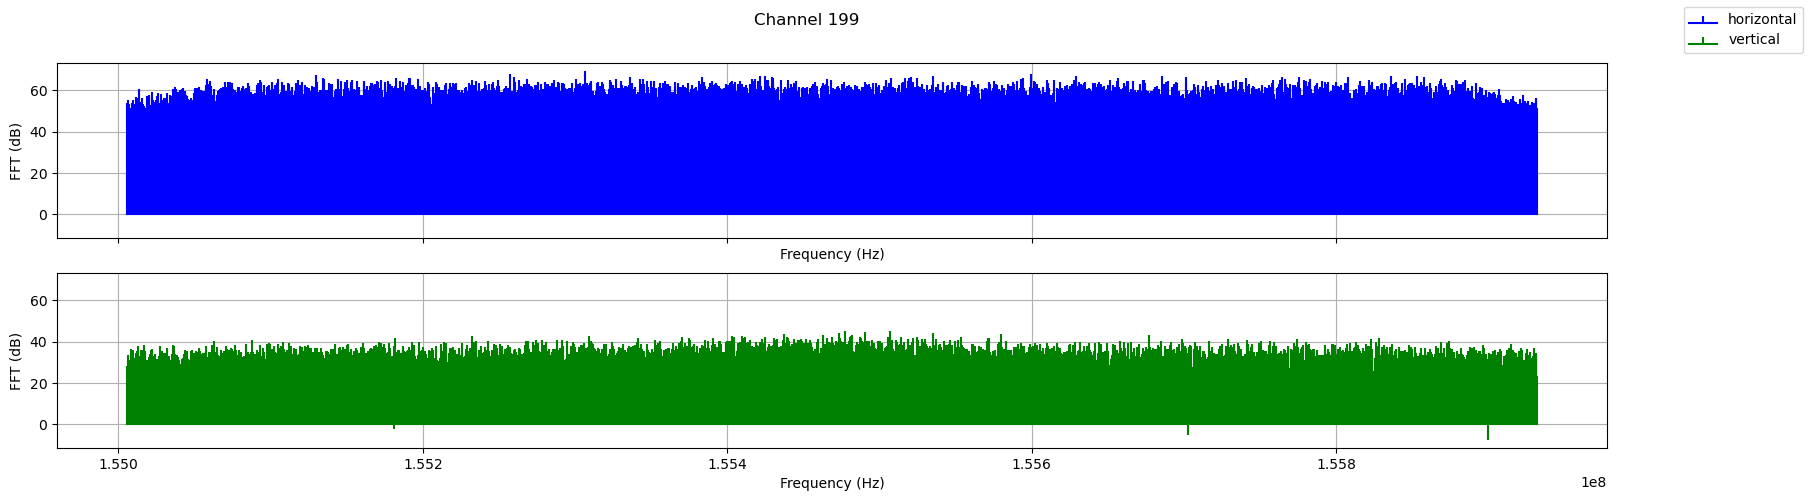

In [164]:
# Plot FFT - combining Re & Im (log scale)
# ref: https://pythonnumericalmethods.berkeley.edu/notebooks/chapter24.04-FFT-in-Python.html
from numpy.fft import fft, fftshift

polarisation_colour = ["blue", "orange", "green", "red"]
ADC_SAMPLE_PERIOD = 1.28e-6
OS_FACTOR = 32/27
# TODO - check if OS factor should be multiplied instead?
sample_rate = (1 / ADC_SAMPLE_PERIOD) * (OS_FACTOR)

for n_chan, channel in enumerate(channel_lookup):
    # n_chan is used to index our all samples data array
    horiz = samples[n_chan][0] + 1j*samples[n_chan][1]
    horiz_fft = 20*np.log10(np.abs(fftshift(fft(horiz))))
    vert = samples[n_chan][2] + 1j*samples[n_chan][3]
    vert_fft = 20*np.log10(np.abs(fftshift(fft(vert))))
    N=len(horiz)
    n = np.arange(N)
    T = N/sample_rate
    #center_channel = int(channel)*781250
    freq = n/T
    print(max(freq))
    print(min(freq))
    freq_t = freq + (int(channel)*781250)-int(max(freq)/2)+1
    # colour = polarisation_colour[n_pol]
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)
    ax1.stem(freq_t, horiz_fft, "blue", markerfmt=" ", basefmt="blue", label="horizontal")
    ax1.set_xlabel("Frequency (Hz)")
    ax1.set_ylabel("FFT (dB)")
    ax1.grid()
    ax2.stem(freq_t, vert_fft, "green", markerfmt=" ", basefmt="green", label="vertical")
    ax2.set_xlabel("Frequency (Hz)")
    ax2.set_ylabel("FFT (dB)")
    ax2.grid()
    fig.suptitle(f"Channel {channel}")
    
    fig.legend()

### SPS to CBF route configuration

In order to route the packet to alveos the P4 switch leverage information from the SPEAD header shown below.

<img src="spead_headers.png" width="1000" title="Figure 2. SPS LFAA headers"/>

In particular, the P4 switch will route traffic using the <beam_id, frequency_id, sub_array_id> tuple to direct the correct traffic to a given Alveo. This routing consists in potential mode from the switch point of view. 

In [ ]:
import json
def print_spead_status():
    """Show SPEAD routing table"""
    packet_sent_p1 = 0
    packet_sent_p2 = 0
    packet_received = 0
    speads = json.loads(connector.speadunicastroutingtable)["Spead"]
    print("SPEAD table:")
    for spead in speads:
        freq = spead["Frequency"]
        beam = spead["Beam"]
        subarray = spead["Sub_array"]
        dstport = spead["port"]
        print(f"Frequency: {freq:<5}  Station Beam: {beam:<6} Sub Array: {subarray:<5} Dest Port: {dstport:<6}")
print_spead_status()

#### Unicast SPEAD routing

In the case where the signal chain is tested end-to-end the SPS traffic is going to be routed only to 1 beamformer. Therefore we can use the unicast SPEAD table. We will see later how to configure the P4 switch so that the traffic is also sent to a CNIC card for traffic capture. 

In our case let's assume that the routing for the following tuples is going to port 12/0. 



In [ ]:
connector.AddSpeadUnicastEntry('{"spead": [{"src": {"frequency": 123, "beam": 12, "sub_array": 1 }, "dst": {"port": "12/0"}}, {"src": {"frequency": 124, "beam": 12, "sub_array": 1 }, "dst": {"port": "12/0"}}]}')

We can check the route in the table again using the `print_spead_status` function from above

In [ ]:
print_spead_status()

In case we need to remove a rule we can use the `RemoveSpeadUnicastEntry` function as follow

In [ ]:
connector.RemoveSpeadUnicastEntry('{"spead": [{"src": {"frequency": 123, "beam": 12, "sub_array": 1 }}]}')

In [ ]:
print_spead_status()

#### Multiply SPEAD traffic

During development and later on when we also have a correlator in place, we would like to send SPS traffic to more than one alveo. In this scenario, we would send traffic to 2 Alveos for a given <beam_id, frequency_id, sub_array_id> tuple. For the purpose of the PI17 integration, these two alveo will be exclusively one PST beamformer and one CNIC personalities. 

In our case let's assume that the routing for the following tuples is going to port 12/0 (PST BF) and 14/0 (CNIC). 


In [ ]:
import json
def print_spead_multi_status():
    """Show SPEAD Multi routing table"""
    packet_sent_p1 = 0
    packet_sent_p2 = 0
    packet_received = 0
    speads = json.loads(connector.speadmultiplierroutingtable)["Spead"]
    multicast_session = json.loads(connector.multicastsessions)["Multicast"]
    print("SPEAD table:")
    for spead in speads:
        freq = spead["Frequency"]
        beam = spead["Beam"]
        subarray = spead["Sub_array"]
        session = spead["session"]
        destPorts = multicast_session[str(session)]
        print(f"Frequency: {freq:<5}  Beam: {beam:<6} Sub Array: {subarray:<5} Dest Ports: {str(destPorts):<15}")
print_spead_multi_status()

In [ ]:
connector.AddMultiplierUnicastEntry('{"spead": [{"src": {"frequency": 123, "beam": 12, "sub_array": 1 }, "dst": {"port_bf": "12/0", "port_corr": "14/0"}}]}')

In [ ]:
connector.RemoveSpeadMultiplierEntry('{"spead": [{"src": {"frequency": 123, "beam": 12, "sub_array": 1 }}]}')

If the route need to be removed or updated, functions removeMultiplierUnicastEntry and updateMultiplierUnicastEntry can be use to do so. Then can both take similar arguments as the add function. 

### Routing to PST

In the context of AA0.5, PSS and PST beamformer will generate respectively 21.6 and 25.6 Gbps of raw data.
Computation for the various data rate can be found [here](https://docs.google.com/spreadsheets/d/1Qza66EnFgSQyeJwhoM_vxqVzMsNe8bHSmg6CI6Q3nSk/edit#gid=978340330).
This raw data is encapsulated in [PSR packets](https://docs.google.com/document/d/1MMu38QMe7gUuV_bCBYHYfI6VxVaJby7c/edit).


In order to route the packet to alveos the P4 switch leverage information from the PSR header shown below.

    +-------+--------+--------+--------+--------+--------+--------+--------+--------+
    | Word  | Byte 0 | Byte 1 | Byte 2 | Byte 3 | Byte 4 | Byte 5 | Byte 6 | Byte 7 |
    +=======+========+========+========+========+========+========+========+========+
    |     0 |                         Packet Sequence Number                        |
    +-------+--------+--------+--------+--------+--------+--------+--------+--------+
    |     1 |                 Timestamp (attoseconds from integer second)           |
    +-------+--------+--------+--------+--------+--------+--------+--------+--------+
    |     2 | Timestamp (seconds from epoch)    |      Channel Separation (mHz)     |
    +-------+--------+--------+--------+--------+--------+--------+--------+--------+
    |     3 |                      First Channel Frequency (mHz)                    |
    +-------+--------+--------+--------+--------+--------+--------+--------+--------+
    |     4 |             Scale #1              |               Scale #2            |
    +-------+--------+--------+--------+--------+--------+--------+--------+--------+
    |     5 |             Scale #3              |               Scale #4            |
    +-------+--------+--------+--------+--------+--------+--------+--------+--------+
    |     6 |       First Channel Number        | Channel per pkt | Valid Ch per pkt|
    +-------+--------+--------+--------+--------+--------+--------+--------+--------+
    |     7 | No. time sample |   Beam Number   |             Magic Word            |
    +-------+--------+--------+--------+--------+--------+--------+--------+--------+
    |     8 | Pkt Dst|DataPrec|Pwr Avg |  ts/wt | O/S num|O/S den | Beamformer ver  |
    +-------+--------+--------+--------+--------+--------+--------+--------+--------+
    |     9 |                                Scan ID                                |
    +-------+--------+--------+--------+--------+--------+--------+--------+--------+
    |    10 |            Offset #1              |               Offset #2           |
    +-------+--------+--------+--------+--------+--------+--------+--------+--------+
    |    11 |            Offset #3              |               Offset #4           |
    +-------+--------+--------+--------+--------+--------+--------+--------+--------+
    
In particular, the P4 switch will route traffic using the beam_id to direct the correct traffic to a given Alveo. This routing consists in potential mode from the switch point of view

* unicast PSR routing. In this mode, a beam_id is routed to a single PSS or PST server.

In [ ]:
import json
def print_psr_status():
    """Show PSR routing table"""
    psrs = json.loads(connector.psrroutingtable)["PSR"]
    print("PSR table:")
    for psr in psrs:
        beam = psr["Beam"]
        port = psr["port"]
        print(f"Beam number: {beam:<5}  Dest Port: {port:<6}")
print_psr_status()

Similarly to what we describe above, we can add and remove entries in the PSR table as follows:

In [ ]:
connector.AddPSREntry('{"psr": [{"src": {"beam": 12 }, "dst": {"port": "16/0"}}]}')

In [ ]:
print_psr_status()

In [ ]:
connector.RemovePSREntry('{"psr": [{"src": {"beam": 12 }}]}')

In [ ]:
print_psr_status()